## Dataset2_month_temp

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Dataset2_month_temp.csv', names = ["month_temp"])

In [3]:
df.head()

,month_temp
0,0.24
1,0.46
2,0.31
3,0.33
4,0.27


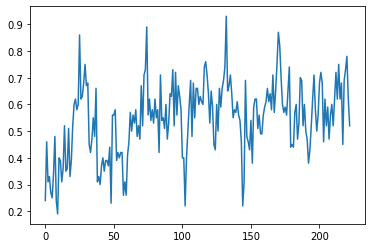

In [4]:
plt.plot(df['month_temp'])

From data plot, we can say that it is a non-stationary data series.

**ADF Test**

In [5]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('month_temp')

Results of Dickey-Fuller Test for  month_temp 

Test Statistic                  -4.044912
p-value                          0.001193
#Lags Used                       3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


ADF test: The test statistic is less than the critical value, so we can reject the null hypothesis. So it is stationary series.
Also P value is less than 0.05 so, from that also we can say it is stationary. 

**KPSS Test**

In [6]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('month_temp')

Results of KPSS Test for  month_temp
Test Statistic            0.664381
p-value                   0.016784
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.


SO from both tests, we can say it is differencing stationary series.

**Differencing with period 1 to make non-stationary data to stationary dataseries.**

In [7]:
df['Diff'] = df['month_temp'].diff(periods=1)

In [8]:
df

,month_temp,Diff
0,0.24,NaN
1,0.46,0.22
2,0.31,-0.15
3,0.33,0.02
4,0.27,-0.06
...,...,...
218,0.69,0.24
219,0.73,0.04
220,0.78,0.05
221,0.62,-0.16


In [9]:
adf_test('Diff')

Results of Dickey-Fuller Test for  Diff 

Test Statistic                -1.306250e+01
p-value                        2.033688e-24
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


p value is less than the 0.05 so data is stationary.

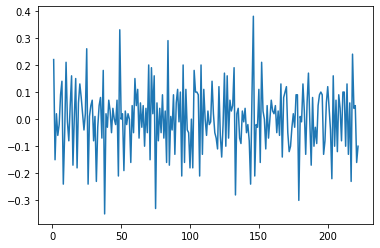

In [10]:
df['Diff'].plot()
plt.show()

In [11]:
data1 = df.iloc[:,0].values
dataset_array1 = [data1[0::1],data1[0::2],data1[0::4],data1[0::8],data1[0::12],data1[0::24]]

In [12]:
def plotting_function(MSE,MAE,name):
  interval = [1,2,3,4,5,6]

  barWidth = 0.25  
  r1 = np.arange(len(interval))
  r2 = [x + barWidth for x in r1]
  
  # Make the plot
  plt.bar(r1, MSE, color='b', width=barWidth, label='MSE')
  plt.bar(r2, MAE, color='g', width=barWidth, label='MAE')

  plt.xlabel('interval', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(interval))], ['1', '2', '4', '8', '12','24'])
  plt.title('MSE and MAE plot for '+(name))
  plt.legend()
  plt.show()
 

**single exponential smoothing**

In [13]:
def single_exp(data,interval,alpha):
  array1=data
  
  fv = np.array([None] * len(array1))
  for i in range(interval):
    fv[i]=array1[i]
   
  for i in range(interval, len(array1)):
    fv[i] = alpha * array1[i-interval] + (1 - alpha) * fv[i - interval]
  array = array1-fv
  arr = pd.DataFrame.from_dict({"month_temp":array1,"Forecasted value":fv,"Error":array})
  return arr

In [14]:
interval = [1,2,4,8,12,24]
mse1=[]
mae1=[]
for i in interval:
  a = single_exp(df.iloc[:,0],i,0.9)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse1.append(round(mse_val,6))
  mae1.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse1)
print('MSE for each interval respectively \n',mae1)

MSE for each interval respectively 
 [0.013647, 0.016664, 0.020484, 0.027139, 0.030466, 0.030698]
MSE for each interval respectively 
 [0.092136, 0.100468, 0.116237, 0.133239, 0.138717, 0.139302]


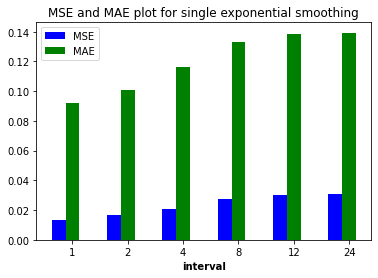

In [15]:
plotting_function(mse1,mae1,'single exponential smoothing')

**Double Exponential Smoothing**

In [16]:
def double_exp(data,interval,alpha,beta):
  array=data
  f = np.array([None] * len(array))
  a = np.array([None] * len(array))
  b = np.array([None] * len(array))
  

  f[0]=data[0]
  a[0] = array[0]
  b[0] = (array[(len(array)-1)] - array[0])/(len(array)-1)

  if interval<2:
    f[1] = a[0]+b[0]
    for i in range(2, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"month_temp":array,"Forecasted value":f,"Error":array-f})
  else:
    for i in range(2,interval):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]

    for i in range(1,interval):
      f[i] = a[i-1] + b[i-1]

    for i in range(interval, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"month_temp":array,"Forecasted value":f,"Error":array-f})
  return arr

In [17]:
interval = [1,2,4,8,12,24]
mse2=[]
mae2=[]
for i in interval:
  a = double_exp(df.iloc[:,0],i,0.9,0.01)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse2.append(round(mse_val,6))
  mae2.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse2)
print('MSE for each interval respectively \n',mae2)

MSE for each interval respectively 
 [0.013771, 0.013833, 0.013959, 0.014219, 0.014489, 0.015362]
MSE for each interval respectively 
 [0.092392, 0.09281, 0.093658, 0.0954, 0.097209, 0.103071]


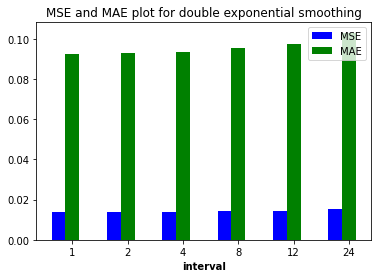

In [18]:
plotting_function(mse2,mae2,'double exponential smoothing')

**Triple Exponential Smoothing**

In [19]:
def initial_trend(data, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(data[i+season_len] - data[i]) / season_len
    return sum / season_len

def initial_seasonal(data, season_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(data)/season_len)
  # compute season averages
  for j in range(n_seasons):
    avg = ((data[(season_len*j):(season_len*j)+season_len]).sum())/float(season_len)
    season_averages.append(avg)
  # initial values
  for i in range(season_len):
    sum = 0.0
    for j in range(n_seasons):
      sum += data[season_len*j+i]-season_averages[j]
    seasonals[i] = sum/n_seasons
  return seasonals

def triple_exp(data, season_len, alpha, beta, gamma, n_preds):
  result = []
  error = []
  seasonals = initial_seasonal(data, season_len)
  for i in range(len(data)+n_preds):
    if i == 0: # initial values
      smooth = data[0]
      trend = initial_trend(data, season_len)
      result.append(data[0])
      continue
    if i >= len(data): # we are forecasting
      m = i - len(data) + 1
      result.append((smooth + m*trend) + seasonals[i%season_len])
    else:
      val = data[i]
      last_smooth, smooth = smooth, alpha*(val-seasonals[i%season_len]) + (1-alpha)*(smooth+trend)
      trend = beta * (smooth-last_smooth) + (1-beta)*trend
      seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
      forecast = smooth+trend+seasonals[i%season_len]
      error = data - forecast
      result.append(forecast)
      
  SE = np.square(error)
  SSE = 0
  for i in SE:
    SSE+= i
  mse_val = SSE/(len(data)-1)
  mae_val = np.sum(abs(error)/len(error))
  return mse_val,mae_val

In [20]:
mse3 = []
mae3 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val = triple_exp(dataframe,1,0.9,0.02,0.95,1)
  mse3.append(round(mse_val,6))
  mae3.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse3)
print('MSE for each interval respectively \n',mae3)

MSE for each interval respectively 
 [0.019402, 0.021931, 0.093266, 0.056315, 0.084807, 0.330376]
MSE for each interval respectively 
 [0.112635, 0.118614, 0.265638, 0.182602, 0.233556, 0.512892]


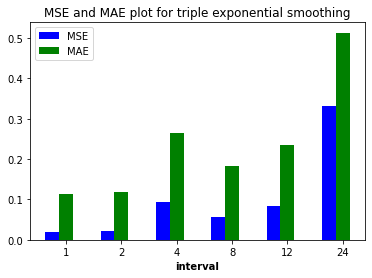

In [21]:
plotting_function(mse3,mae3,'triple exponential smoothing')

**ACF PACF Plot**

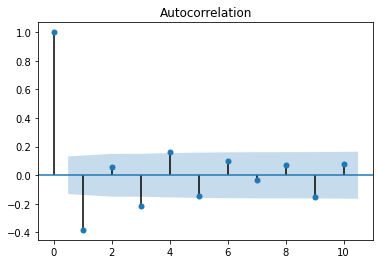

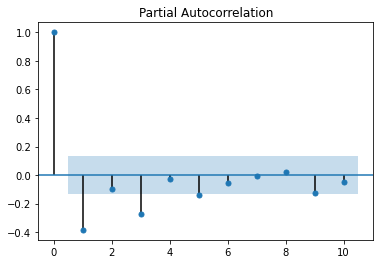

In [22]:
plot_acf(df.iloc[:,1].dropna(), lags=10)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=10)
plt.show()

Checking for
AR(1), AR(3), AR(5) : from partial autocorelation plot.

MA(1),MA(3),MA(5) : from autocorelation plot.

pmdarima package install

In [23]:
!pip3 install pmdarima

In [24]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=5, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-348.834, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=377.837, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-305.484, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=164.742, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-350.560, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-337.521, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-355.547, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-351.456, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-356.991, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-347.901, Time=0.36 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-355.302, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-354.965, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-355.692, Time=0.40 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AI

**AR model**

In [25]:
from statsmodels.tsa.arima_model import ARIMA
def ar_model(data):
  model=ARIMA(data,order=(2,0,0)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [26]:
mse4 = []
mae4 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ar_model(dataframe)
  mse4.append(round(mse_val,6))
  mae4.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse4)
print('MSE for each interval respectively \n',mae4)

MSE for each interval respectively 
 [0.011325, 0.014669, 0.016696, 0.018922, 0.034283, 0.02252]
MSE for each interval respectively 
 [0.085273, 0.095156, 0.097788, 0.109238, 0.152433, 0.121277]


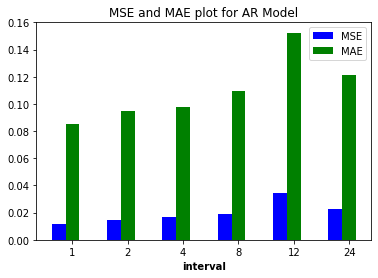

In [27]:
plotting_function(mse4,mae4,'AR Model')

**MA Model**

In [34]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,3)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [35]:
mse5 = []
mae5 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ma_model(dataframe)
  mse5.append(round(mse_val,6))
  mae5.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse5)
print('MSE for each interval respectively \n',mae5)

MSE for each interval respectively 
 [0.0122, 0.015474, 0.016045, 0.018175, 0.030591, 0.019547]
MSE for each interval respectively 
 [0.087731, 0.097666, 0.098421, 0.103227, 0.146241, 0.113056]


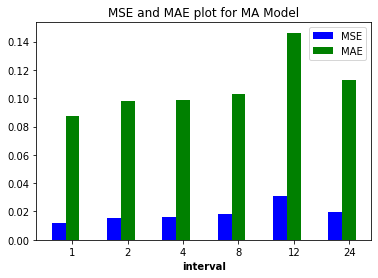

In [36]:
plotting_function(mse5,mae5,'MA Model')

**ARIMA Model**

In [47]:
def arima_model(data):
  model=ARIMA(data,order=(0,1,1)).fit()
  prediction = model.fittedvalues
  data = np.delete(data,[0])
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [48]:
mse6 = []
mae6 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = arima_model(dataframe)
  mse6.append(round(mse_val,6))
  mae6.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse6)
print('MSE for each interval respectively \n',mae6)

MSE for each interval respectively 
 [0.323165, 0.33308, 0.312935, 0.311519, 0.354497, 0.263685]
MSE for each interval respectively 
 [0.545577, 0.551101, 0.531739, 0.523724, 0.550318, 0.490124]


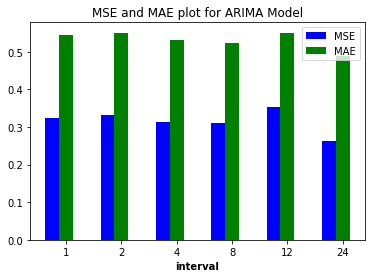

In [49]:
plotting_function(mse6,mae6,'ARIMA Model')